In [55]:
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

## Data Loading

In [56]:
mental_health_df = pd.read_csv("../data/raw/Mental_health_dataset.csv")

In [57]:
mental_health_df.head()

,Timestamp,Content,Sentiment,Topics,Mental Health Indicator,Source Platform,Language
0,23-08-22 09:22,Feeling disconnected from everyone around me.,negative,anxiety,1,Facebook,English
1,23-01-10 03:05,Struggling to find motivation for even the sma...,negative,anxiety,1,Instagram,English
2,23-04-11 09:15,Feeling quite overwhelmed by everything. Need ...,negative,anxiety,1,Instagram,English
3,23-03-23 11:19,Had a great workout today! Feeling energized a...,positive,well-being,0,Reddit,English
4,23-09-26 19:29,Struggling to find motivation for even the sma...,negative,loneliness,1,Instagram,English


## Data Analysis

### Sentiment Distribution

In [58]:
mental_health_df["Sentiment"].value_counts()

Sentiment
negative    29865
positive    20135
Name: count, dtype: int64

<Axes: xlabel='Sentiment', ylabel='count'>

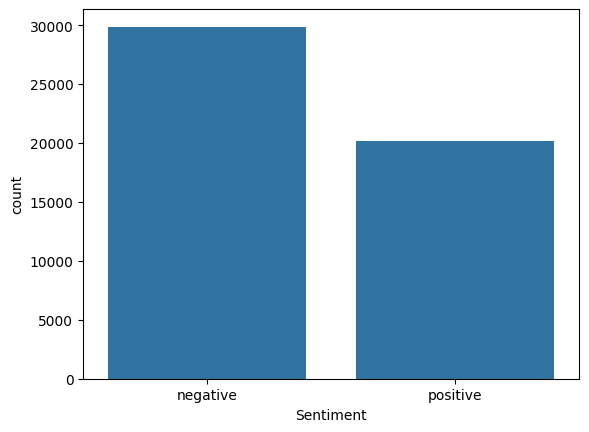

In [59]:

sns.countplot(x="Sentiment", data=mental_health_df)

### Topic distribution

In [60]:
mental_health_df["Topics"].value_counts()

Topics
loneliness    10077
depression     9949
anxiety        9839
happiness      6777
well-being     6751
success        6607
Name: count, dtype: int64

<Axes: xlabel='Topics', ylabel='count'>

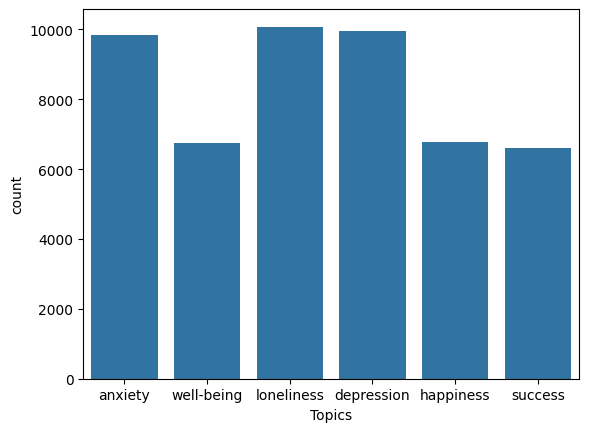

In [61]:
sns.countplot(x="Topics", data=mental_health_df)

## Data cleaning

In [62]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a cleaning function
def clean_text(text):
    # Remove URLs, special characters, and numbers
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W+|\d+', ' ', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove stopwords and apply lemmatization
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join tokens back into a string
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

# Apply the cleaning function to the Content column
mental_health_df['Content'] = mental_health_df['Content'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [63]:
mental_health_df.head()

,Timestamp,Content,Sentiment,Topics,Mental Health Indicator,Source Platform,Language
0,23-08-22 09:22,feeling disconnected everyone around,negative,anxiety,1,Facebook,English
1,23-01-10 03:05,struggling find motivation even smallest task,negative,anxiety,1,Instagram,English
2,23-04-11 09:15,feeling quite overwhelmed everything need talk...,negative,anxiety,1,Instagram,English
3,23-03-23 11:19,great workout today feeling energized positive,positive,well-being,0,Reddit,English
4,23-09-26 19:29,struggling find motivation even smallest task,negative,loneliness,1,Instagram,English


## Data splitting

In [64]:
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target label (y)
X = mental_health_df['Content']
y = mental_health_df['Mental Health Indicator']

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 35000
Validation set size: 7500
Testing set size: 7500


## Feature Engineeting

* a) Text vectorization

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# Fit and transform the training data to create TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation and test sets
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


* b) Handle imbalanced data

In [66]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE on the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# Check the class distribution
print(f"Class distribution in y_train after SMOTE: {pd.Series(y_train_smote).value_counts()}")


Class distribution in y_train after SMOTE: Mental Health Indicator
0    20876
1    20876
Name: count, dtype: int64


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Fit the model on the training data
log_reg.fit(X_train_smote, y_train_smote)

# Predict on the validation set
y_val_pred = log_reg.predict(X_val_tfidf)

# Evaluate the model
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2980
           1       1.00      1.00      1.00      4520

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



## Validation

In [71]:
# Example custom data
custom_data = [
    "Feeling overwhelmed and anxious about the future.",
    "Had a great day with friends, feeling really happy!",
    "Struggling to cope with my workload and feeling stressed.",
    "I'm feeling quite happy today, but a bit anxious about tomorrow.",
    "Just finished a great book on ancient history and I'm feeling inspired!",
    "Lately, I've been feeling overwhelmed with worry about things that are out of my control.",
    "Starting meditation has significantly improved my overall sense of well-being.",
    "The weather has been quite unpredictable this week, with rain and sunshine alternating.",
    "No matter what I do, there's a persistent feeling of sadness that I can't seem to shake off.",
    "After months of therapy, I'm finally starting to see improvements in how I feel about myself and my life.",
    "Recent studies suggest that spending time in nature can have a positive effect on mental health.",
    "Deadlines are approaching fast, and I'm starting to doubt if I can handle the pressure.",
    "I am so grateful for the support group I've found; it's comforting to know I'm not alone in this journey.",
    "I'm hopeful about the future but anxious about the changes it might bring to my personal life and mental health."
    
]

# Apply the cleaning function defined previously
cleaned_custom_data = [clean_text(text) for text in custom_data]
print(cleaned_custom_data)
# Transform the custom data
custom_data_tfidf = tfidf_vectorizer.transform(cleaned_custom_data)

# Making predictions
custom_predictions = log_reg.predict(custom_data_tfidf)

print(custom_predictions)


['feeling overwhelmed anxious future', 'great day friend feeling really happy', 'struggling cope workload feeling stressed', 'feeling quite happy today bit anxious tomorrow', 'finished great book ancient history feeling inspired', 'lately feeling overwhelmed worry thing control', 'starting meditation significantly improved overall sense well', 'weather quite unpredictable week rain sunshine alternating', 'matter persistent feeling sadness seem shake', 'month therapy finally starting see improvement feel life', 'recent study suggest spending time nature positive effect mental health', 'deadline approaching fast starting doubt handle pressure', 'grateful support group found comforting know alone journey', 'hopeful future anxious change might bring personal life mental health']
[1 0 1 1 0 1 1 1 1 1 0 1 0 1]


## Save model

In [69]:
from joblib import dump
from sklearn.feature_extraction.text import TfidfVectorizer



# Save the fitted TF-IDF Vectorizer
dump(tfidf_vectorizer, '../models/mh_tfidf_vectorizer.joblib')

# Save the trained logistic regression model
dump(log_reg, '../models/mh_logistic_regression_model.joblib')



['../models/mh_logistic_regression_model.joblib']